# Mesh deformation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# mesh parsing
import openfoamparser as Ofpp
# interpolator
from scipy.interpolate import Rbf
# deformation
from pygem import FFD

In [28]:
def upper_layer_idxes(points):
    return points[:,2] > 0

def upper_layer(*arrs):
    points = arrs[0]
    if len(arrs) > 1:
        return (arr[upper_layer_idxes(points)] for arr in arrs)
    else:
        return points[upper_layer_idxes(points)]
    
def scatter3d(arr, figsize=(8,8), s=10, draw=True, ax=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='3d')
        
    for a in arr:
        ax.scatter(*a.T, s=s, alpha=1)
        
    if draw:
        plt.show()
    else:
        return ax

## Extraction of mesh points
We use OFPP to extract points from an OpenFOAM mesh. First of all we employ the method `FoamMesh` to create a `mesh` object which contains all the relevant information. Then we define some convenient functions to extract data which we're interested in (like the obstacle, or walls). Finally we show how those functions work with a small example.

In [3]:
mesh_path = '.'
# we load the OpenFOAM mesh
mesh = Ofpp.FoamMesh(mesh_path)

We define the following auxiliary functions:
+ `extract_boundary_faces`: returns a 3D array which consists in a list of faces, represented by lists of points, which compose a given obstacle;

In [5]:
def extract_boundary_faces(mesh, key):
    obstacle = mesh.boundary[key]
    obstacle_faces = np.array(mesh.faces[obstacle.start:obstacle.start+obstacle.num])
    obstacle_points = np.apply_along_axis(lambda v: np.array([mesh.points[x] for x in v]), 
                                          axis=1, arr=obstacle_faces)
    return obstacle_points

+ `extract_boundary_points`: returns a 2D array which consists in a list of points which compose a given obstacle.

In [6]:
def extract_boundary_points(mesh, key):
    l = []
    for v in extract_boundary_faces(mesh, key):
        l.extend(v)
    return np.array(l)

+ `walls_points`: returns a 2D array which consists in a list of points which compose all the "walls" in the mesh (top, bottom, inlet, outlet). The indexing is the same of the output of `extract_boundary_points`.

In [37]:
def walls_points(mesh):
    keys = [b'inlet', b'outlet', b'top', b'bottom']
    return np.concatenate([extract_boundary_points(mesh, k) for k in keys])

We then plot the obstacle and the walls for the mesh.

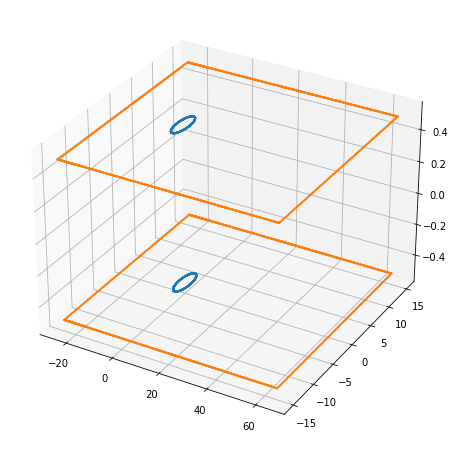

In [29]:
obstacle = extract_boundary_points(mesh, b'obstacle')
scatter3d([obstacle, walls_points(mesh)], s=1)

## Interpolation
We intend to use an interpolator to determine the new position of the points which compose the mesh. We define some auxiliary functions:
+ `train_interpolators`: trains two interpolators (one for `x` and one for `y` axis) using the new position of the deformed obstacle against the old position, and the fact that walls do not move from their old position;
+ `interpolate_points`: uses the interpolators to find the new position of the given list of points.

Interpolation happens only on `x` and `y` because we consider a simplified case.

In [40]:
def train_interpolators(old_walls, old_obstacle_points, new_obstacle_points, **kwargs):    
    old_obstacle_points, new_obstacle_points = upper_layer(old_obstacle_points, new_obstacle_points)
    old_walls = upper_layer(old_walls)
    
    train_points = np.vstack([old_walls, old_obstacle_points])
    train_values = np.vstack([old_walls, new_obstacle_points])
    
    train_points, uindexes = np.unique(train_points, return_index=True, axis=0)
    train_values = train_values[uindexes]
    
    return (Rbf(*train_points.T, train_values[:,i], **kwargs) for i in range(2))

def interpolate_points(old_points, *interpolators):
    return np.vstack([[intp(*old_points.T) for intp in interpolators], old_points[:,2]]).T

## Deformation
We use the `FFD` deformation from [PyGem](https://github.com/mathLab/PyGeM) (for a reference check [this](http://mathlab.github.io/PyGeM/tutorial-1-ffd.html) tutorial) to deform the original obstacle (the upper and lower faces of a cylinder). First of all we define a `transform` function which provides the deformation.

In [20]:
def transform(vec):
    ffd = FFD([2, 2, 2])

    ffd.box_origin = np.array([-2.6,-2.6,-1.1])
    ffd.box_length = np.array([5.2,5.2,2.2])

    ffd.array_mu_x[1, 1, 0] = 0.3
    ffd.array_mu_y[1, 1, 0] = 0.3

    ffd.array_mu_x[1, 1, 1] = 0.3
    ffd.array_mu_y[1, 1, 1] = 0.3
    
    return ffd(vec)

We then operate the deformation and plot the result, against the old version of the obstacle.

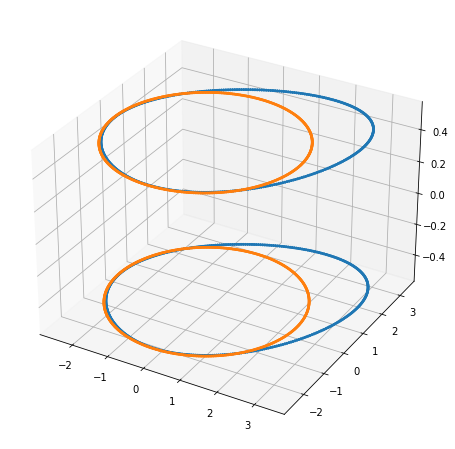

In [33]:
scatter3d([transform(obstacle), obstacle], s=3)

## New mesh
At this point we can use the ingredients we prepared in the last sections to interpolate the new mesh after the deformation of the obstacle. First of all, we train the interpolators (function `train_interpolators`) using the functions `wall_coords` (which returns the position of the walls, which do not move), and the new points which compose the obstacle after the deformation (function `transform`).

In [41]:
interpx, interpy = train_interpolators(walls_points(mesh), 
                                        obstacle,
                                        transform(obstacle))

We then use the interpolators to determine the new position of the points which compose the mesh. This is a resource-intensive computation and may slow down the device on which you're running this notebook.

In [43]:
new_mesh_points = interpolate_points(mesh.points, interpx, interpy)

The last thing to do is to plot the mesh after the interpolation. In order to see what happened we prefer a 2D scatter plot of the upper part of the mesh (`z=0.5`).

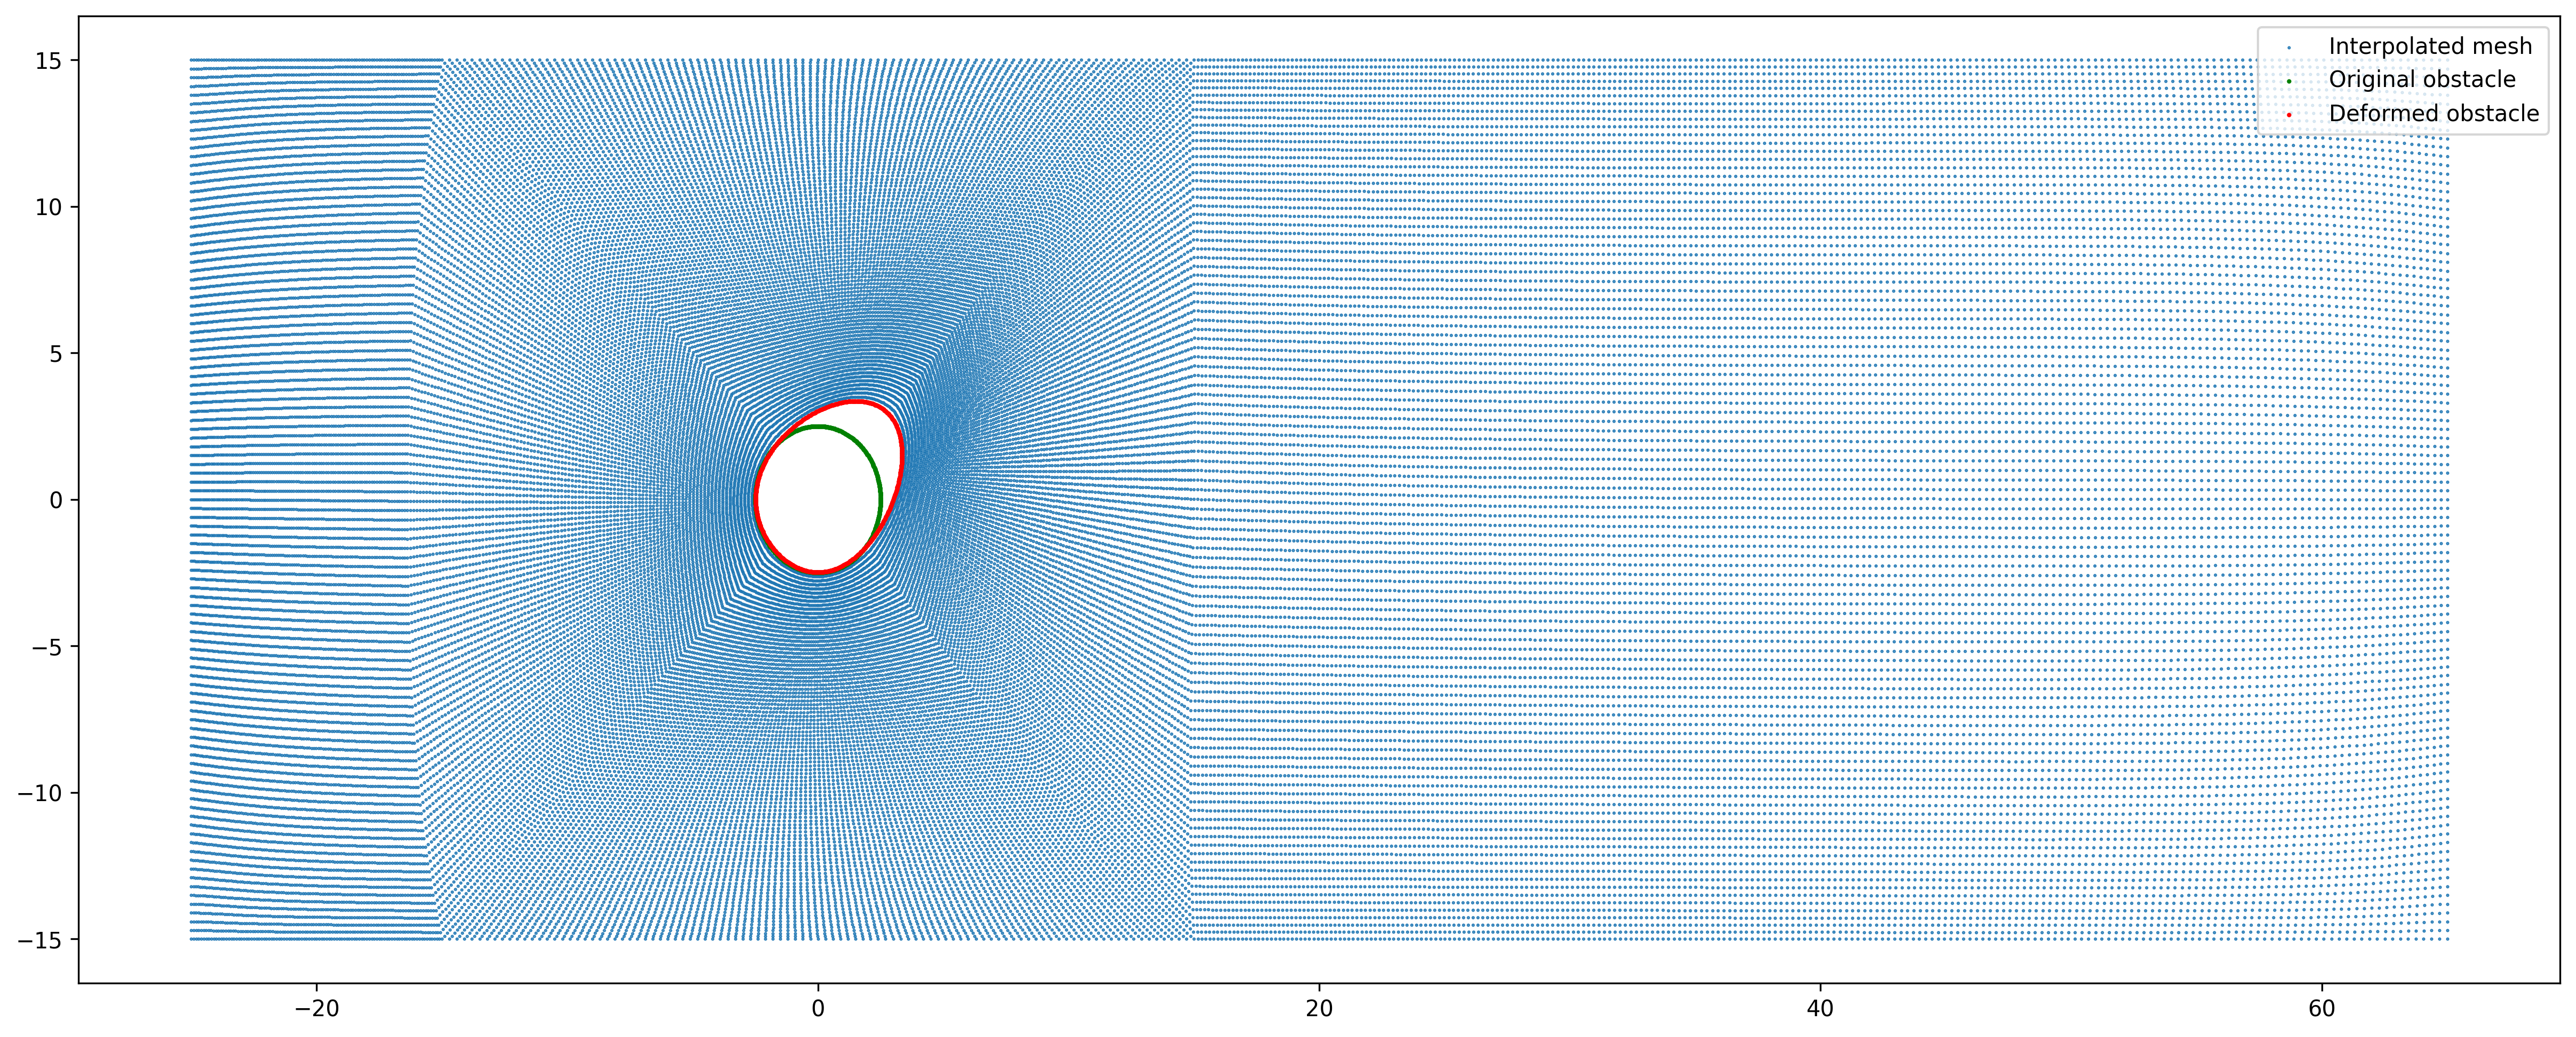

In [58]:
plt.figure(figsize=(20,8), dpi=300)
plt.scatter(*upper_layer(new_mesh_points)[:,:2].T, s=0.2, label='Interpolated mesh')
plt.scatter(*upper_layer(obstacle)[:,:2].T, s=1, color='g', label='Original obstacle')
plt.scatter(*upper_layer(transform(obstacle))[:,:2].T, s=1, color='r', label='Deformed obstacle')

plt.legend()
plt.show()